<a href="https://colab.research.google.com/github/vgudur/HouseSalesAnalytics/blob/main/Troy_House_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analysis of Residental and Condo Sales of Troy, MI
<p><a href="https://troymi.gov/departments/assessing/sales_and_studies.php/">Troy RealEstate Sales analysis</a></p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

sns.set()
pd.set_option('display.float_format', lambda x: '%.5f' % x)

plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
from scipy.stats import norm

##Helper Functions

In [26]:
## Helper Functions
from IPython.core.display import display, HTML
def large_print(data, size=140):
    display( HTML('<span style="font-size:'+ str(size * 2) +'%; line-height:'+str(size)+'%"><p><p>' + data + '</p></p></span>'))

## Encoding helper functions
def using_cat_encoding(dset, lstvariable):
  # fisrt convert the column to category type
  for variable in lstvariable:
    var_new_col = variable + '_category_type'
    var_col_encode = variable + '_encode_val'
    dset[var_new_col] =  dset[variable].astype('category')
    dset[var_col_encode] = dset[var_new_col].cat.codes
    dset.drop(columns=[var_new_col] , inplace=True)
  return dset

def using_index_encoding(dset, variable):
  gle = LabelEncoder()
  var_col_encode = variable + '_encode_val'
  dset[var_col_encode] = gle.fit_transform(dset[variable])
  return dset

def using_onehot_encoding (dset , lstvariable):
  return pd.get_dummies(dset, columns=lstvariable, prefix=lstvariable)

## Apply Scaling, Standardization and Normalization on Numeric colmns
def min_max_scaling(dset, minval =0, maxval = 1 ,usescikit=False):
  from sklearn.preprocessing import MinMaxScaler
  if usescikit == False :    
    # apply the min-max scaling in Pandas using the .min() and .max() methods
    #print ( 'path 1.0 \n')
    # copy the dataframe
    df_norm = dset.copy()
    if ( (minval==0) & (maxval == 1) ):
      ##print ( 'path1.1 \n')
      '''for column in df_norm.columns:        
        df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min()) 
      '''
      df_norm = (dset-dset.min())/(dset.max()-dset.min())
    else:
        #print ( 'path1.2 \n')
        for column in df_norm.columns:
          x, y = df_norm[column].min(),  df_norm[column].max()
          ##  df_norm[column] = (df_norm[column] - minval) / (maxval - minval)
          df_norm[column]  = (df_norm[column]  -  df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())  * (maxval - minval) + minval
  else :   
    # apply the min-max scaling using scikit MinMaxScaler
    ##print ( 'path 2.0 using scikit MinMaxScaler\n')   
    # create a scaler object
    scaler = MinMaxScaler(feature_range=(minval, maxval))
    # fit and transform the data
    df_norm = pd.DataFrame(scaler.fit_transform(dset), columns=dset.columns)
  return df_norm

def ZScore_Standarization_Scaling(dset,usescikit=False):
  from sklearn.preprocessing import StandardScaler

  if usescikit == False :    
    # apply the z-score method in Pandas using the .mean() and .std() methods
    # copy the dataframe
    df_norm = dset.copy()
    for column in dset.columns:
        df_norm[column] = (df_norm[column] - df_norm[column].mean()) / df_norm[column].std()        
    return df_norm
  else :   
    # apply the min-max scaling using scikit MinMaxScaler
    ##print ( 'path 2.0 using scikit MinMaxScaler\n')   
    # create a scaler object
    scaler = StandardScaler()
    # fit and transform the data
    df_norm = pd.DataFrame(scaler.fit_transform(dset), columns=dset.columns)
    return df_norm
def robust_scaling ( df):
  from sklearn import preprocessing
  num_features = df.select_dtypes([np.number]).columns.tolist()
  df_copy1 = pd.DataFrame ( df, columns=list(num_features))  
  r_scaler = preprocessing.RobustScaler()
  df_r = r_scaler.fit_transform(df_copy1)
  col_names = list(df_copy1.columns)
  df_r = pd.DataFrame(df_r , columns=col_names )
  return df_r
def Normalization_Method ( dset):
  from sklearn import preprocessing
  num_features = dset.select_dtypes([np.number]).columns.tolist()
  df_copy1 = pd.DataFrame ( dset, columns=list(num_features))  
  n_scaler = preprocessing.RobustScaler()
  df_normalized = n_scaler.fit_transform(df_copy1)
  col_names = list(df_copy1.columns)
  df_normalized = pd.DataFrame(df_normalized , columns=col_names )
  return df_normalized

def Plot_Scalling_Variations(dset) :
  num_features = dset.select_dtypes([np.number]).columns.tolist()
  ##print ( num_features)
  lst_ScaleTypes = ['None', 'MinMax' , 'Roburst', 'Standard', 'Normalize']
  ##lst_ScaleTypes = ['None']
  fig, axes_types = plt.subplots( ncols=  len(lst_ScaleTypes), figsize=(30,10))
  strTitle = 'Test'
  for i, axes_Type in enumerate(fig.axes):
    strTitle = ""
    lst_scaletype = lst_ScaleTypes[i]
    if lst_scaletype == 'None':
      df_New = pd.DataFrame ( dset, columns=list(num_features))
      strTitle = 'Original Distributions'
    elif lst_scaletype == 'MinMax':
      df_New = min_max_scaling ( dset , usescikit=True )
      strTitle = 'MinMax Scaler / ReScaling - Data Normalization'
    elif lst_scaletype == 'Standard':
      df_New = ZScore_Standarization_Scaling ( dset ,usescikit=True )
      strTitle = 'Standar Scaler / Z-Score Normalization'
    elif lst_scaletype == 'Roburst':
      df_New  =  robust_scaling ( dset)
      strTitle = 'Roburst Scaling'
    else:
      ## lst_scaletype == 'Normalize':
      df_New =  Normalization_Method ( dset)
      strTitle = 'Scikit Normalizer'
    ##sns.distplot(df_New, hist=False, kde=True, rug=True, ax=axes_Type)
    axes_Type.set_title (strTitle)
    for col in num_features:
      ##print(col)
      sns.kdeplot( df_New[col] , ax = axes_Type)
    plt.legend ( num_features )

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor 
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import calibration_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing

import numpy as np
import pandas as pd
import pprint 

def run_cross_Validation(X,y,  scoring_columns, modeltype='mnb'): 
  if ( modeltype =='LR'):
    model=LinearRegression()
  if (modeltype == 'Logistic'):
    ## Logistic Regression Model
    model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')

  if (modeltype == 'svm'):
    ## Support Vector Machine Model
    model = svm.SVC(decision_function_shape="ovo")

  if (modeltype == 'RFC'):
    ##Random Forest Model
    model = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
  if (modeltype == 'RFR'):
    ##Random Forest Model
    model = RandomForestRegressor(random_state=0)


  if (modeltype == 'nn'):
    ##Neural Network Model
    model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(150, 10), random_state=1)
  
  if (modeltype == 'nb'):
    ## Gaussian Naive Bayes
    model = GaussianNB()
      
  if (modeltype == 'mnb'):
    ## Multinominal Naive Bayes
    model = MultinomialNB()
  if (modeltype == 'KNN'):
    ## KNN
    model = KNeighborsClassifier()
  if (modeltype == 'XGB'):
    ## XGB
    model = XGBClassifier()
  if ( modeltype =="DTC"):
    model =  DecisionTreeClassifier(max_depth=2, random_state=42)  
  if ( modeltype =="DTR"):
    X = preprocessing.normalize(X)
    model =  DecisionTreeRegressor(random_state=0)
 
  ## CV can be integer or a KFold.  Try both
  kfold = KFold(n_splits=10, shuffle=True)
  cv_results = cross_validate(model, X, y, cv= kfold , scoring=scoring_columns, return_train_score=True)

  ##pprint.pprint( "============CV Results for debugging============\n" )
  ##pprint.pprint(cv_results )

  ##type(cv_results)

  ##print ('\n avg test_accuracy : ', cv_results['test_accuracy'].mean())
  return cv_results

def  Run_Model (x_tr, y_tr, x_tst, y_tst, feature_cols, usescaling=False, show_roc=False, modeltype='mnb', bDebugPrint=False):

  # Create a Logistic Regression Object, perform Logistic Regression
  x_tr = pd.DataFrame(x_tr)
  y_tr = pd.DataFrame(y_tr)
  x_tst = pd.DataFrame(x_tst)
  y_tst = pd.DataFrame(y_tst)
  
  bRegression = False
  # Scale the data
  if (usescaling == True ):
    x_tr = ZScore_Standarization_Scaling(x_tr)
    x_tst = ZScore_Standarization_Scaling(x_tst)
  
  if ( bDebugPrint):
    print ( "Running ML Model ")
  if ( modeltype =='LR'):
    model=LinearRegression().fit(x_tr, y_tr)
    bRegression = True
  if (modeltype == 'Logistic'):
    ## Logistic Regression Model
    model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(x_tr, y_tr)
    bRegression = True

  if (modeltype == 'svm'):
    ## Support Vector Machine Model
    model = svm.SVC(decision_function_shape="ovo").fit(x_tr, y_tr)

  if (modeltype == 'RFC'):
    ##Random Forest Model
    model = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0).fit(x_tr, y_tr)
  if (modeltype == 'RFR'):
    ##Random Forest Model
    model = RandomForestRegressor(random_state=0).fit(x_tr, y_tr)
    bRegression = True

  if (modeltype == 'nn'):
    ##Neural Network Model
    model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(150, 10), random_state=1).fit(x_tr, y_tr)
  
  if (modeltype == 'nb'):
    ## Gaussian Naive Bayes
    model = GaussianNB().fit(x_tr, y_tr)
      
  if (modeltype == 'mnb'):
    ## Multinominal Naive Bayes
    model = MultinomialNB().fit(x_tr, y_tr)
  if (modeltype == 'KNN'):
    ## KNN
    model = KNeighborsClassifier().fit(x_tr, y_tr)
  if (modeltype == 'XGB'):
    ## XGB
    model = XGBClassifier().fit(x_tr, y_tr)
  if ( modeltype =="DTC"):
    model =  DecisionTreeClassifier(max_depth=2, random_state=42).fit(x_tr, y_tr)
  if ( modeltype =="DTR"):
    model =  DecisionTreeRegressor(random_state=0).fit(x_tr, y_tr)
    bRegression = True

  tr_score = model.score(x_tr, y_tr)   
  tst_score =   model.score(x_tst, y_tst)

  y_pred = model.predict(x_tst)
  results_model_type,  score_train, score_test  = modeltype, tr_score ,   tst_score 
  if ( bDebugPrint):
    large_print ( "{0}  Model Accuracy for training  :{1}  ,  Testing :{2}".format( modeltype, tr_score ,   tst_score   ))
    if ( bRegression):
      ##For regression problems the metrics used to evaluate an algorithm are
      ## mean absolute error, mean squared error, and root mean squared error. Execute the following code to find these values:

      from sklearn import metrics

      print('Mean Absolute Error:', metrics.mean_absolute_error(y_tst, y_pred))
      print('Mean Squared Error:', metrics.mean_squared_error(y_tst, y_pred))
      print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_tst, y_pred)))

    else:
      large_print('=============show confusion matrix values=============', 60)
      # Show the Confusion Matrix
      cnf_matrix  = confusion_matrix(y_tst, y_pred)
      print ('\n\t\t \n',cnf_matrix )
      large_print('=============Visualize confusion Matrix=============', 60)
      #Visualize confusion Matrix  
      fig, ax1 = plt.subplots(figsize=(10,5))
      tick_marks = np.arange(len(feature_cols))
      plt.xticks(tick_marks, feature_cols)
      plt.yticks(tick_marks, feature_cols)
      # create heatmap
      sns.heatmap(pd.DataFrame(cnf_matrix ), cmap="YlGnBu" , annot=True,  fmt='g', ax=ax1)
      ax1.xaxis.set_label_position("top")
      plt.title('Confusion matrix', y=1.1)
      plt.ylabel('Actual label')
      plt.xlabel('Predicted label')
      plt.show()    
      large_print('=============Classification report=============\n', 70)
      print(classification_report(y_tst, y_pred))

    if ( modeltype =="DTC"):
      large_print('=============Graph Visual of Decision tree=============\n', 70)
      
      import graphviz
      from sklearn import tree
      text_representation = tree.export_text(model)
      print(text_representation)

      fig = plt.figure(figsize=(25,20))
      tree.plot_tree(model, 
                        feature_names=feature_cols,  
                        class_names= 'target',
                        filled=True)

      dot_data = tree.export_graphviz(model, out_file=None, 
                                    feature_names=feature_cols,
                                    class_names= 'target',
                                    filled=True)

      # Draw graph
      graph = graphviz.Source(dot_data, format="png") 
      graph.render("decision_tree_graphivz")

    if ( show_roc== True):
      ## Show ROC Curve 
      print ( "Show ROC Curve")
      y_pred_proba = log_reg.predict_proba(x_tst)[::,1]
      fpr, tpr, _ = metrics.roc_curve(y_tst,  y_pred_proba)
      auc = metrics.roc_auc_score(y_tst, y_pred_proba)
      plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
      plt.legend(loc=4)
      plt.show()
      ## find accuracy
      print ('\n\t\t AUC Score  between 0.5 - 1 is perfect classifier. Accuracy of the mdoel is',   ) 
      ## AUC score 1 represents perfect classifier, and 0.5 represents a worthless classifier.
  return results_model_type, score_train, score_test

def  Run_Plot_Classification ( X_train, y_train, X_test, y_test ):
  import numpy as np
  np.random.seed(0)

  import matplotlib.pyplot as plt

  from sklearn import datasets
  from sklearn.naive_bayes import GaussianNB
  from sklearn.linear_model import LogisticRegression
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.svm import LinearSVC
  from sklearn.calibration import calibration_curve
  from sklearn.naive_bayes import MultinomialNB


 ## X, y = datasets.make_classification(n_samples=100000, n_features=20,
 ##                                     n_informative=2, n_redundant=2)

  train_samples = 100  # Samples used for training the models

  X_train = pd.DataFrame(X_train)
  y_train = pd.DataFrame(y_train)
  X_test = pd.DataFrame(X_test)
  y_test = pd.DataFrame(y_test)

  # Create classifiers
  lr = LogisticRegression()
  gnb = GaussianNB()
  svc = LinearSVC(C=1.0)
  rfc = RandomForestClassifier()
  nb = MultinomialNB ()


  # #############################################################################
  # Plot calibration plots

  plt.figure(figsize=(10, 10))
  ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
  ax2 = plt.subplot2grid((3, 1), (2, 0))

  ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
  for clf, name in [(lr, 'Logistic'),
                    (gnb, 'Naive Bayes'),
                    (svc, 'Support Vector Classification'),
                    (rfc, 'Random Forest')
                    ##,                    (nb, 'Multinomial NB')
                    ]:
      clf.fit(X_train, y_train)
      if hasattr(clf, "predict_proba"):
          prob_pos = clf.predict_proba(X_test)[:, 1]
      else:  # use decision function
          prob_pos = clf.decision_function(X_test)
          prob_pos = \
              (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
      fraction_of_positives, mean_predicted_value = \
          calibration_curve(y_test, prob_pos, n_bins=10)

      ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
              label="%s" % (name, ))

      ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
              histtype="step", lw=2)

  ax1.set_ylabel("Fraction of positives")
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend(loc="lower right")
  ax1.set_title('Calibration plots  (reliability curve)')

  ax2.set_xlabel("Mean predicted value")
  ax2.set_ylabel("Count")
  ax2.legend(loc="upper center", ncol=2)

  plt.tight_layout()
  plt.show()

## PReProcessing of data
def describe_features ( dset, featurelist, NumberValues=True):
  ##num_features = dset.select_dtypes([np.number]).columns.tolist()
  ##cat_features = dset.select_dtypes( exclude = [np.number] ).columns.tolist()
  if NumberValues == True : 
    astat_df = dset[featurelist].describe().loc[['min','max','mean', 'std']].T.sort_values('max')
  else:
    astat_df= dset[featurelist].describe()  
  return astat_df

def find_unique_values_in_Colums ( dset, bprintdebug = False):
  if ( bprintdebug == True ):
    print('\nAll Feature Count: ', len(dset.columns))
  discrete_feature = [feature for feature in dset.columns 
                      if len(dset[feature].unique())<50
                      and feature not in ['Id']]

  if ( bprintdebug == True ):
    print('\nDiscrete Feature Count: ', len(discrete_feature))
    for feature in discrete_feature:
      print ( '\nUnique lables for feature :  {0} \n {1}'.format( feature, dset[feature].unique() )  )
  return discrete_feature

# What percentage of data is clean?
def calculate_missing_values_percent_by_columns(diff):
  for col in diff.columns:
    pct_missing = np.mean(diff[col].isnull())
    pct_missing = round(pct_missing*100, 3)
    pct_clean = 100 - pct_missing
    
    print('{0: >20} - pecent clean: {1: >7}% - percent missing: {2: >7}%'.format(col,pct_clean,  pct_missing))
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 *( df.isnull().sum() / len(df) )
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = { 0 : 'Zero Values',1 : 'Missing Values', 2 : '% of Missing Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * ( mz_table['Total Zero Missing Values'] / len(df) )
        mz_table['Data Type'] = df.dtypes
        mz_table['Data Length'] = len(df)
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Missing Values', ascending=False).round(3)

        ##print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
        ##    "There are " + str(mz_table.shape[0]) +
         ##     " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table
def  find_Null_Value_Cnt_by_Feature ( dset):
  nulls_df = pd.DataFrame(dset.isnull().sum().sort_values(ascending=False)[:25])
  nulls_df.columns = ['Null Count']
  nulls_df.index.name = 'Feature'
  return nulls_df

def PreProcessing_Step1 ( dset , bprintdebug = False) :
 
  num_features = dset.select_dtypes([np.number]).columns.tolist()
  cat_features = dset.select_dtypes( exclude = [np.number] ).columns.tolist()
  if cat_features.count('ID') > 0 :
    cat_features.remove('ID')
  if cat_features.count('Name') > 0 :
    cat_features.remove('Name')
  if ( bprintdebug == True ):
    print ( '\nSample data\n {0} \n'.format(dset.head(5)) )
    print ( "\nDataFrame shape: {0}\n".format(dset.shape))
    print ( "\nDataFrame size: {0}\n".format(dset.size))

    print ( "\nDataFrame types: {0}\n".format(dset.dtypes))

    
    print ("\n num_features: {0} \n cat_features: {1} \n".format(num_features,cat_features  ) )
    print   ("""
              *********************************
              Percent of Cleanness in the data - Method
              *********************************
             """)
    print ( find_Null_Value_Cnt_by_Feature(dset ) )

    print ("""
    *********************************
    Data Stats are 
    *********************************
          """)
    print ( "\nNumerica feature stats are \n")
    df_sta1 = describe_features(dset , num_features).sort_values(by='max', ascending=False)
    print ( df_sta1 )
    print ("\nCategorica feature stats are \n", describe_features(dset , cat_features, NumberValues=False) )
    print ( """
    *********************************
    Finding Unique values in discrete features
    *********************************
          """)
  discrete_features = find_unique_values_in_Colums ( dset, bprintdebug)
  ##for cval in cat_features:
    ##print ( cval)
    ##if  discrete_features.count('cval') <= 0:
      ##cat_features.remove(cval)
  return num_features, cat_features

def  show_Correlation_of_lables ( dset, target ) :
  print("\nFinding correlation between features \n")
  # Finding the relations between the variables.
  hd_corr_matrix= dset.corr()
  print ( "All feature correlation values \n", hd_corr_matrix)

  target_corr = hd_corr_matrix[target]


  print ( "\Target correlation with other features\n",  target_corr.sort_values(ascending=False))

  print ( "\nTop 5 features positively impacted target \n" ,  hd_corr_matrix[target].sort_values(ascending=False)[:5], '\n')
  print ( "\nBottom 5 features negatively impacted target \n" , hd_corr_matrix[target].sort_values(ascending=False)[-5:])

  for k,v in target_corr.items():
      if(abs(v) > 0.01) and k != target:
          neg = ''
          if(v < 0):
              neg = 'negative '
          print(f'\nThe {k} aspect shows {(v ** 2) * 100:.2f}% {neg}influence on the targer')
  print ( 'Show Correlation Matrix between features \n')
  fig, ax = plt.subplots(figsize=(15,8))         # Sample figsize in inches

  sns.heatmap(hd_corr_matrix,cmap="BrBG",annot=True, ax=ax)
  plt.show()

  target_corr = target_corr.drop(labels=[target])
  # Plot a bar chart to show the influence factors
  sns.set(palette="deep", rc={"figure.figsize": [7, 3]})
  target_corr.plot(kind='barh')

def  show_distribution_of_data ( dset , collist):
  df_copy1 = pd.DataFrame ( dset, columns=list(collist))
  print ( 'Distibution of all numerical features \n\n' ) 
  ## see the frequency of all numerical columns and outliers
  sns.set(style='whitegrid', palette="deep", font_scale=1, rc={"figure.figsize": [20, 8]})
  ## distribution of all numerica columns
  ##df_house[num_features].hist(bins=10, figsize=(10, 5), layout=(3, 3))
  df_copy1.hist(bins=15, figsize=(15, 8), layout=(3  , 6 ))


def plot_target_by_Variable(dset , variables, target):
  listsize = len( variables)
  ncol = 2
  if (  listsize < ncol ):
    ncol = listsize
  nrow = round(len(variables)// ncol )
  print ( " Plot  {0} of  size {1} in col: {2} and rows: {3}" .format( variables, listsize,  ncol , nrow) )

  fig, axes_types = plt.subplots(nrows= nrow , ncols= ncol, sharex=False, sharey=True, squeeze=False, figsize=(10,10))
  for i, ax in enumerate(fig.axes):
      if i <  listsize:
          ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
          xlabel = variables[i]
          sns.scatterplot(x= xlabel , y= target, data=dset, ax=ax, hue = xlabel)
          ##sns.boxplot(x= xlabel , y= target, data=dset, ax=ax, hue = xlabel)
          plt.legend ( xlabel )
  fig.tight_layout()

##Step 1 - Load Data

In [2]:
df_base = pd.read_csv('https://vgs3public.s3.us-east-2.amazonaws.com/RetailHouseSales/Troy_House_Price_Valuation.csv')
df_base.head()

,ID,Residence_Type,ECF,Street Address,Sale_Date,Price,Type,Class,Year_Built,Square_Feet,Basement_Square_Feet,Basement_Finished_Recreation,Basement_Finished_Living,Full_Baths,Half_Baths,Price_per_sqft
0,C0201_02-152-047_1,Condo,C0201,1131 Alameda,42867,210000,Ranch,C,2004,1316,0,0.00000,0.00000,2,0,159.57000
1,C0201_02-152-050_2,Condo,C0201,1120 Alameda,43119,210000,Ranch,C,2004,1316,0,0.00000,0.00000,2,0,159.57000
2,C0201_02-152-068_3,Condo,C0201,1175 Alameda,43368,212000,Ranch,C,2004,1316,0,0.00000,0.00000,2,0,161.09000
3,C0201_02-152-004_4,Condo,C0201,1015 Alameda,43348,235000,Ranch,C,2003,1457,0,0.00000,0.00000,2,0,161.29000
4,C0201_02-152-033_5,Condo,C0201,1096 Alameda,43452,226000,Ranch,C,2004,1457,0,0.00000,0.00000,2,0,155.11000


In [3]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1998 entries, 0 to 1997
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            1998 non-null   object 
 1   Residence_Type                1998 non-null   object 
 2   ECF                           1998 non-null   object 
 3   Street Address                1998 non-null   object 
 4   Sale_Date                     1998 non-null   int64  
 5   Price                         1998 non-null   int64  
 6   Type                          1998 non-null   object 
 7   Class                         1998 non-null   object 
 8   Year_Built                    1998 non-null   int64  
 9   Square_Feet                   1998 non-null   int64  
 10  Basement_Square_Feet          1998 non-null   int64  
 11  Basement_Finished_Recreation  1997 non-null   float64
 12  Basement_Finished_Living      1997 non-null   float64
 13  Ful

##Step2 - Preprocess the data

####Consolidate  sqft attributes

In [21]:
df_base_v2 =  df_base.assign(Total_Sqft=lambda x: (x['Square_Feet'] + x['Basement_Square_Feet'] + x['Basement_Finished_Recreation'] + x['Basement_Finished_Living']  ))

df_base_v2 = df_base_v2.drop(columns=['Square_Feet','Basement_Square_Feet','Basement_Finished_Recreation', 'Basement_Finished_Living'])

df_base_v2["Residence_Type"] = df_base_v2["Residence_Type"].astype("category")
df_base_v2["Type"] = df_base_v2["Type"].astype("category")
df_base_v2["Class"] = df_base_v2["Class"].astype("category")
df_base_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1998 entries, 0 to 1997
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ID              1998 non-null   object  
 1   Residence_Type  1998 non-null   category
 2   ECF             1998 non-null   object  
 3   Street Address  1998 non-null   object  
 4   Sale_Date       1998 non-null   int64   
 5   Price           1998 non-null   int64   
 6   Type            1998 non-null   category
 7   Class           1998 non-null   category
 8   Year_Built      1998 non-null   int64   
 9   Full_Baths      1998 non-null   int64   
 10  Half_Baths      1998 non-null   int64   
 11  Price_per_sqft  1998 non-null   float64 
 12  Total_Sqft      1997 non-null   float64 
dtypes: category(3), float64(2), int64(5), object(3)
memory usage: 162.7+ KB


#### Cast Date column

In [22]:
print ( "\nHouse DataFrame shape: {0}\n".format(df_base_v2.shape))
##print ( "\nHouse DataFrame info: {0}\n".format(df_house.info()))
df_base_v3 = df_base_v2.drop(columns=['ECF', 'ID', 'Street Address'])


###Convert SaleDate to actual date type
print ( "Fist check existing type of Date filed : ", df_base_v3.Sale_Date.dtype )

# Check first if we will have wrong conversions
print('Nulls in conversion', pd.to_datetime(df_base_v3['Sale_Date']).isnull().sum())
print('NaN in conversion', pd.to_datetime(df_base_v3['Sale_Date']).isna().sum())

# Convert and rename column
if pd.to_datetime(df_base_v3['Sale_Date']).isna().sum() == 0 and pd.to_datetime(df_base_v3['Sale_Date']).isnull().sum() == 0:
    df_base_v3['SaleDate'] = pd.to_datetime(df_base_v3['Sale_Date'])
    ##print('conversion of strings to datetime was successful')
##df_house.SaleDate.describe()
print ( "Check New field data type : ", df_base_v3.SaleDate.dtype )
df_base_v3.drop(columns=['Sale_Date'] , inplace=True)

##df_base_v3.describe(include='all')

##Do a barplot of houses sold per year
df_base_v3['Sale_Year'] = pd.DatetimeIndex(df_base_v3['SaleDate']).year
df_base_v3['Sale_Month'] = pd.DatetimeIndex(df_base_v3['SaleDate']).month


House DataFrame shape: (1998, 13)

Fist check existing type of Date filed :  int64
Nulls in conversion 0
NaN in conversion 0
Check New field data type :  datetime64[ns]


#### Drop missing values

In [23]:
## drop missing records from both datasets
# making new data frame with dropped NA values  
df_house_sales = df_base_v3.dropna(axis = 0, how ='any')


print("\nCleaning NA values in training set \n\tLength before: {0} Length After : {1}".format( len(df_base_v3), len(df_house_sales)    )    ) 
print("\n\tNumber of rows with at least 1 NA value: ", ( len(df_base_v3) - len(df_house_sales)  )) 

df_house_sales.info()



Cleaning NA values in training set 
	Length before: 1998 Length After : 1997

	Number of rows with at least 1 NA value:  1
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1997 entries, 0 to 1997
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Residence_Type  1997 non-null   category      
 1   Price           1997 non-null   int64         
 2   Type            1997 non-null   category      
 3   Class           1997 non-null   category      
 4   Year_Built      1997 non-null   int64         
 5   Full_Baths      1997 non-null   int64         
 6   Half_Baths      1997 non-null   int64         
 7   Price_per_sqft  1997 non-null   float64       
 8   Total_Sqft      1997 non-null   float64       
 9   SaleDate        1997 non-null   datetime64[ns]
 10  Sale_Year       1997 non-null   int64         
 11  Sale_Month      1997 non-null   int64         
dtypes: category(3), datetime64[ns](1), f

In [33]:
num_Features,  cat_Features = PreProcessing_Step1(df_house_sales, bprintdebug=False)

num_Features.remove('Sale_Month')
cat_Features.remove("SaleDate")
print ("\n num_features: {0} \n cat_features: {1} \n".format(num_Features,cat_Features  ) )
df_house_sales.describe(include='all')


 num_features: ['Price', 'Year_Built', 'Full_Baths', 'Half_Baths', 'Price_per_sqft', 'Total_Sqft', 'Sale_Year'] 
 cat_features: ['Residence_Type', 'Type', 'Class'] 



,Residence_Type,Price,Type,Class,Year_Built,Full_Baths,Half_Baths,Price_per_sqft,Total_Sqft,SaleDate,Sale_Year,Sale_Month
count,1997,1997.00000,1997,1997,1997.00000,1997.00000,1997.00000,1997.00000,1997.00000,1997,1997.00000,1997.00000
unique,2,nan,7,6,nan,nan,nan,nan,nan,479,nan,nan
top,House,nan,Colonial,C,nan,nan,nan,nan,nan,1970-01-01 00:00:00.000043251,nan,nan
freq,1696,nan,1267,1359,nan,nan,nan,nan,nan,24,nan,nan
first,NaN,nan,NaN,NaN,nan,nan,nan,nan,nan,1970-01-01 00:00:00.000000001,nan,nan
last,NaN,nan,NaN,NaN,nan,nan,nan,nan,nan,1970-01-01 00:00:00.000043553,nan,nan
mean,NaN,348377.83275,NaN,NaN,1982.78317,2.02704,0.78868,160.61104,3546.24136,NaN,1970.00000,1.00000
std,NaN,144106.85377,NaN,NaN,19.55060,0.77425,0.50984,24.96752,1571.14924,NaN,0.00000,0.00000
min,NaN,89900.00000,NaN,NaN,1901.00000,1.00000,0.00000,48.75000,768.00000,NaN,1970.00000,1.00000
25%,NaN,252000.00000,NaN,NaN,1970.00000,2.00000,0.00000,144.41000,2382.00000,NaN,1970.00000,1.00000


### Distribution of categorical features


Distribution of categorical values 

['Residence_Type', 'Type', 'Class']


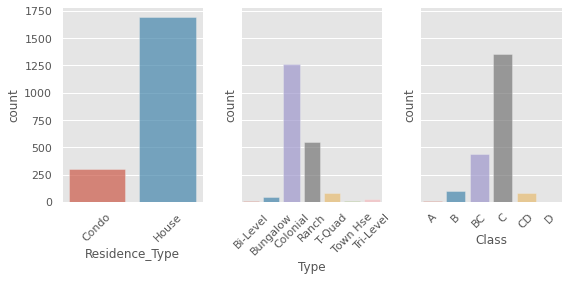

In [34]:
print ( "\nDistribution of categorical values \n")
## distribution of categorical columns
listsize = len( cat_Features)
print ( cat_Features)
ncol = 3
if (  listsize < ncol ):
  ncol = listsize
nrow = round(len(cat_Features)/ ncol )

fig, axes_types = plt.subplots(nrows= nrow , ncols= ncol, sharex=False, sharey=True, squeeze=True, figsize=(8,4))

for i, ax in enumerate(fig.axes):
    if i <  listsize:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        xlabel = cat_Features[i]
        sns.countplot(x= df_house_sales[xlabel] , alpha=0.7, data=df_house_sales, ax=ax)

fig.tight_layout()

###Distribution of numeical columns

Distibution of all numerical features 




array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fab5ec6d5f8>,
      dtype=object)

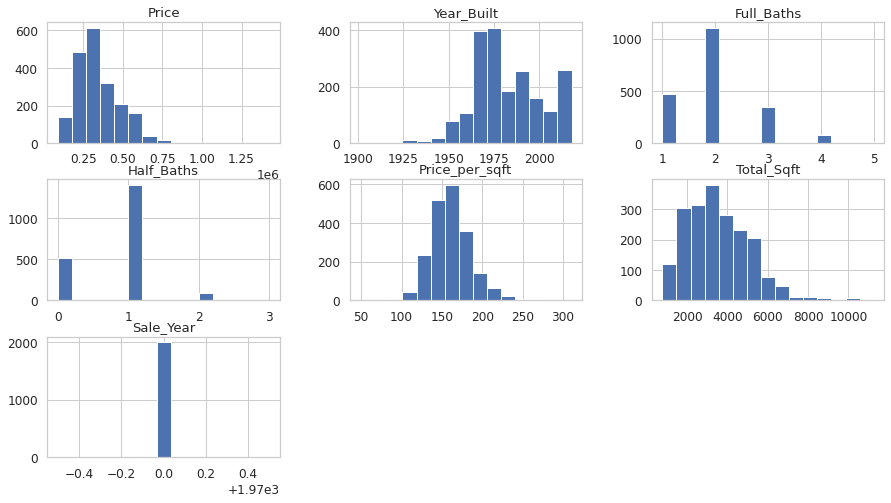

In [35]:
print ( 'Distibution of all numerical features \n\n' ) 
## see the frequency of all numerical columns and outliers
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [20, 11]})
## distribution of all numerica columns
##df_house[num_features].hist(bins=10, figsize=(10, 5), layout=(3, 3))
df_house_sales[num_Features].hist(bins=15, figsize=(15, 8), layout=(3, 3))

In [52]:
def plot_Sale_Price_by_Variable_v2(dset , variables):
  listsize = len( variables)
  ncol = 3
  if (  listsize < ncol ):
    ncol = listsize
  nrow = round(len(variables)/ ncol )+1
  #print ( ' Plot  {} of  size {} in col{} and rows{}' , variables, listsize,  ncol , nrow)

  fig, axes_types = plt.subplots(nrows= nrow , ncols= ncol, sharex=False, sharey=True, squeeze=True, figsize=(15, 7) )
  for i, ax in enumerate(fig.axes):
      if i <  listsize:
          ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
          xlabel = variables[i]
          sns.boxplot(x= xlabel , y='Price', data=dset, ax=ax)
  fig.tight_layout()
  '''
  fig, ax = plt.subplots( ncols=3, nrows= ( len(variables)//3 ) + 1, sharex=False, sharey=True, squeeze=True, figsize=(15,7))
  for variable, subplot in zip(variables, ax.flatten()):
        sns.boxplot(x=variable, y='SalePrice', data=dset, ax=subplot)
        for label in subplot.get_xticklabels():
          label.set_rotation(45)  
  '''


Distribution of SalePrice by numerical values 



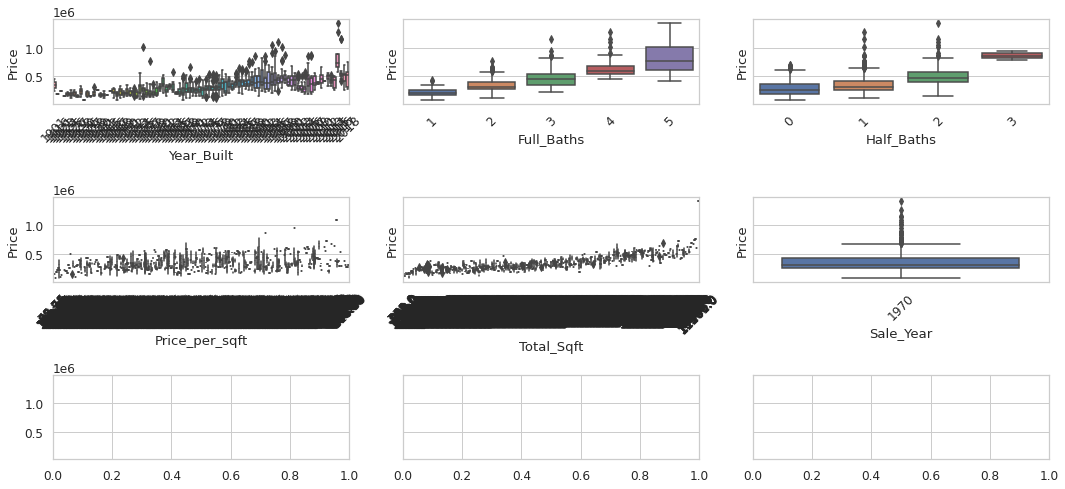

In [72]:
## 
print ( "\nDistribution of SalePrice by numerical values \n")
tst_num_features =  num_Features
if tst_num_features.count('Price') > 0:
    tst_num_features.remove('Price')
if tst_num_features.count('Sale_Month') > 0:
    tst_num_features.remove ('Sale_Month')
plot_Sale_Price_by_Variable_v2(df_house_sales, tst_num_features)


Distribution of SalePrice by categorical values 



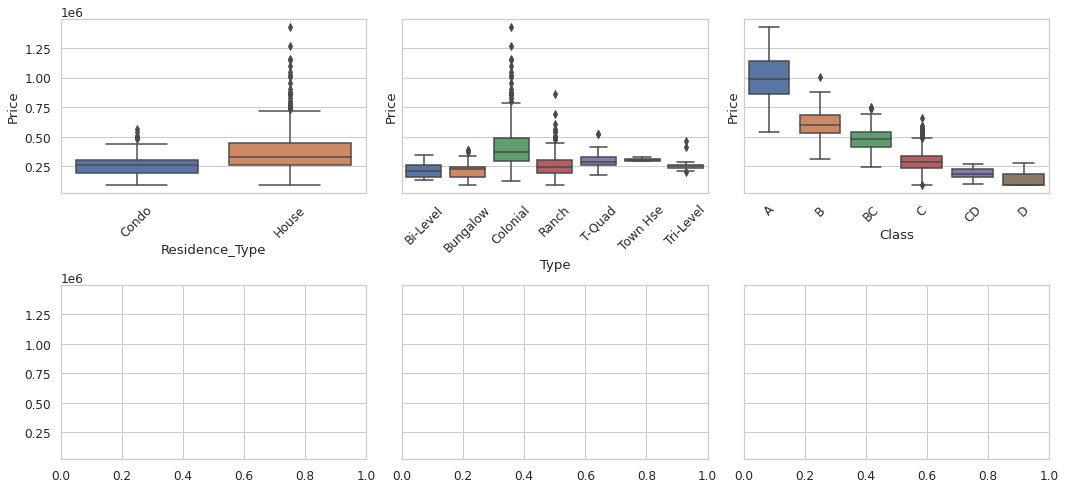

In [58]:

categorical_Columns = cat_Features
print ( "\nDistribution of SalePrice by categorical values \n")
plot_Sale_Price_by_Variable_v2(df_house_sales, categorical_Columns)

### Avg.Price and Sale Charts

In [76]:
df_avg_price_by_bedroom_v1 = df_house_sales.groupby(['Type', 'Residence_Type', 'Total_Sqft']).agg(
        avg_price = pd.NamedAgg(column='Price', aggfunc='mean'),
        Total_Sales = pd.NamedAgg(column='Price', aggfunc='count')
    ).reset_index()

df_house_segments = df_avg_price_by_bedroom_v1.sort_values("Total_Sqft", ascending=True)

Text(0.5, 1.0, 'Total Sales by Residence_Type')

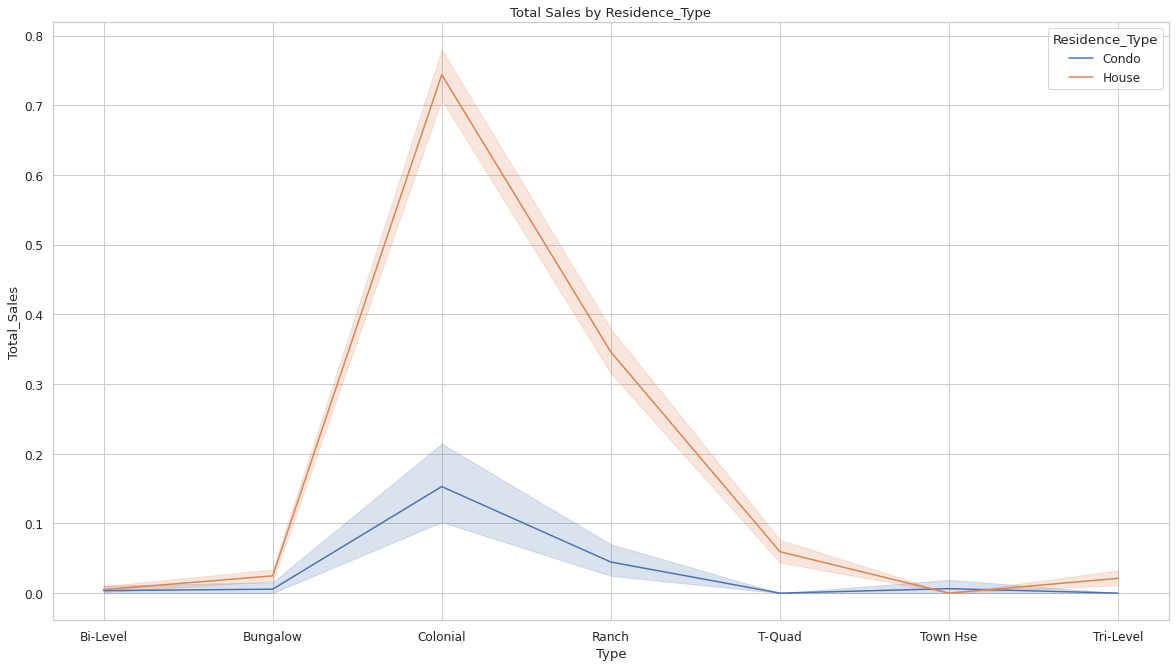

In [78]:
ax = sns.lineplot(x="Type", y = "Total_Sales"  , hue="Residence_Type",  data=df_house_segments)
ax.set_title ( 'Total Sales by Residence_Type')

Text(0.5, 1.0, 'Avg.Price by Residence_Type')

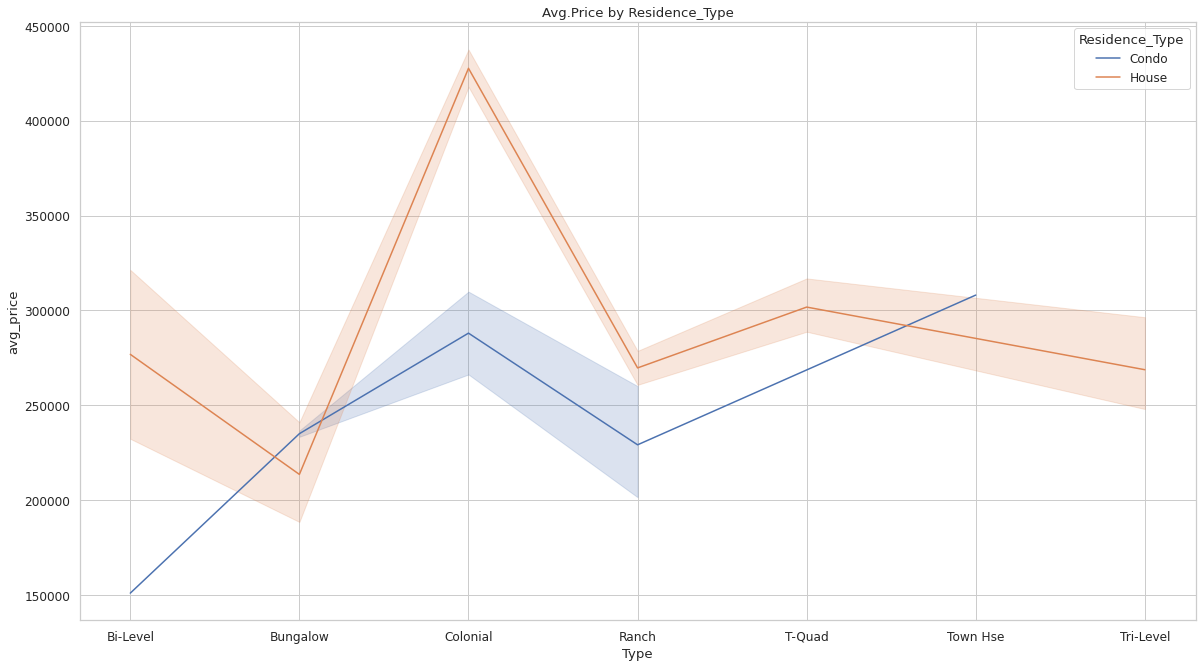

In [79]:
ax = sns.lineplot(x="Type", y = "avg_price"  , hue="Residence_Type",  data=df_house_segments)
ax.set_title ( 'Avg.Price by Residence_Type')

###Find Outliers

In [65]:
def pct_method(data, level):
    '''
    The percentile method cuts off a predefined percentage amount from the top and the bottom of a distribution (if both sides are desired). 
    In order not to cut off too much of the observation, a cutoff value of 1% is commonly used. That means that the top and bottom 1% of the a variable is labelled as an outlier.
    '''
    # Upper and lower limits by percentiles
    upper = np.percentile(data, 100 - level)
    lower = np.percentile(data, level)
    # Returning the upper and lower limits
    print ( "{0} Percent method limits \n lower: {1} \n upper: {2} ".format(  level, lower, upper )  )
    return [lower, upper]

def iqr_method(data):
    '''
    The interquartile range approach first calculates the interquartile range (IQR) of the data. The IQR is defined as the difference between the 75 and 25 percentile of a variable. 
    This IQR is then multiplied with 1.5. Any data that is then further away than the 75 percentile plus 1.5*IQR or 25 percentile minus 1.5*IQR is classified as an outlier.
    '''
    # Calculating the IQR
    perc_75 = np.percentile(data, 75)
    perc_25 = np.percentile(data, 25)
    iqr_range = perc_75 - perc_25
    # Obtaining the lower and upper bound
    iqr_upper = perc_75 + 1.5 * iqr_range
    iqr_lower = perc_25 - 1.5 * iqr_range
    # Returning the upper and lower limits
    return [iqr_lower, iqr_upper]
def std_method(dfdata, stdlevel=3):
    '''
    The standard deviation approach arises from the so called empirical rule which states that given a normally distributed variable, approximately 99.7% of the data is within three standard deviations. This approach then classifies any observation which is more than three standard deviation below or above the mean as an outlier. 
    It is essential to note though that this approach only works if the data is approximately Gaussian.
    '''
    # Creating three standard deviations away boundaries
    stdval = dfdata.std()
    upper_limit = dfdata.mean() + stdlevel * stdval
    lower_limit = dfdata.mean() - stdlevel * stdval
    # Returning the upper and lower limits
    print ( "{0} std method limits \n lower: {1} \n upper: {2} ".format(  stdlevel, lower_limit, upper_limit )  )
    return  lower_limit, upper_limit

def outlier_bool(data, level=1, continuous=False, log=False):
  # Taking logs is specified
  if log is True:
    data = np.log(data + 1)
  # Obtaining the ranges
  pct_range = pct_method(data, level)
  iqr_range = iqr_method(data)
  std_range = std_method(data)
  if continuous is False:
          # Setting the lower limit fixed for discrete variables
          low_limit = np.min(data)
          high_limit = np.max([pct_range[1],
                              iqr_range[1],
                              std_range[1]])
  elif continuous is True:
          low_limit = np.min([pct_range[0],
                              iqr_range[0],
                              std_range[0]])
          high_limit = np.max([pct_range[1],
                              iqr_range[1],
                              std_range[1]])
  # Restrict the data with the minimum and maximum
  outlier = data.between(low_limit, high_limit)
  # Return boolean
  return outlier
    
def Outlier_Finding_IQR(sourcedf):
  print ("\n Finding Outliers using IQR scoring techinique\n")
  Q1 = sourcedf.quantile(0.25)
  Q3 = sourcedf.quantile(0.75)
  IQR = Q3 - Q1
  df_after_clearning_step2 = sourcedf[~((sourcedf < (Q1 - 1.5 * IQR)) |(sourcedf > (Q3 + 1.5 * IQR))).any(axis=1)]
  print ( "\n Before {0} and after{1} clearning the outliers \n".format( sourcedf.shape, df_after_clearning_step2.shape ) )
  print ( "\n Before \n {0} \n after \n{1} \n  \n".format( sourcedf.describe(include='all'), df_after_clearning_step2.describe(include='all') ) ) 

In [64]:
skew_beforelog  = df_house_sales.Price.skew()
kurtios_beforelog  = df_house_sales.Price.kurt()

target = np.log(df_house_sales.Price)

skew_afterlog  = target.skew()
kurtios_afterlog  = target.kurt()

print("Without log Skewness : {0}%f  Kurtios: {1}%f\n\nAfter log Skewness : {2}%f  Kurtios: {3}%f  ".format( skew_beforelog , kurtios_beforelog , skew_afterlog, kurtios_afterlog)  )


Without log Skewness : 1.416104120213902%f  Kurtios: 4.324753764255816%f

After log Skewness : -0.007933069836555496%f  Kurtios: 0.09362470101359976%f  


In [ ]:
# We can eliminate top 10% and bottom 10% to find middle prices.
sourcedf = df_salePrice
lower_limit , upper_limit = pct_method (df_salePrice,10)
df_house_v2 = df_house[ ~ ((sourcedf>upper_limit) | (  sourcedf <lower_limit) ) .any(axis=1) ]
print ( "\n shape of the data before dropping 10% outliers {0}\n shape of the data after dropping 10% outliers : {1} \n".format( df_house.shape, df_house_v2.shape ) )
print ( "\n Before \n {0} \n\n after \n{1} \n  \n".format( df_house.describe(include='all'), df_house_v2.describe(include='all') ) ) 

###Scaling the features

In [88]:
##X = extract all columns except `Price`
##y = extract `Price` column
x_cols = num_Features
if (x_cols.count('ID'))>0:
  x_cols.remove('ID')
y_cols = 'Price'
print ("\n Features: {0} \n Target: {1} \n".format(x_cols,y_cols  ) )


 Features: ['Year_Built', 'Full_Baths', 'Half_Baths', 'Total_Sqft', 'Sale_Year'] 
 Target: Price 



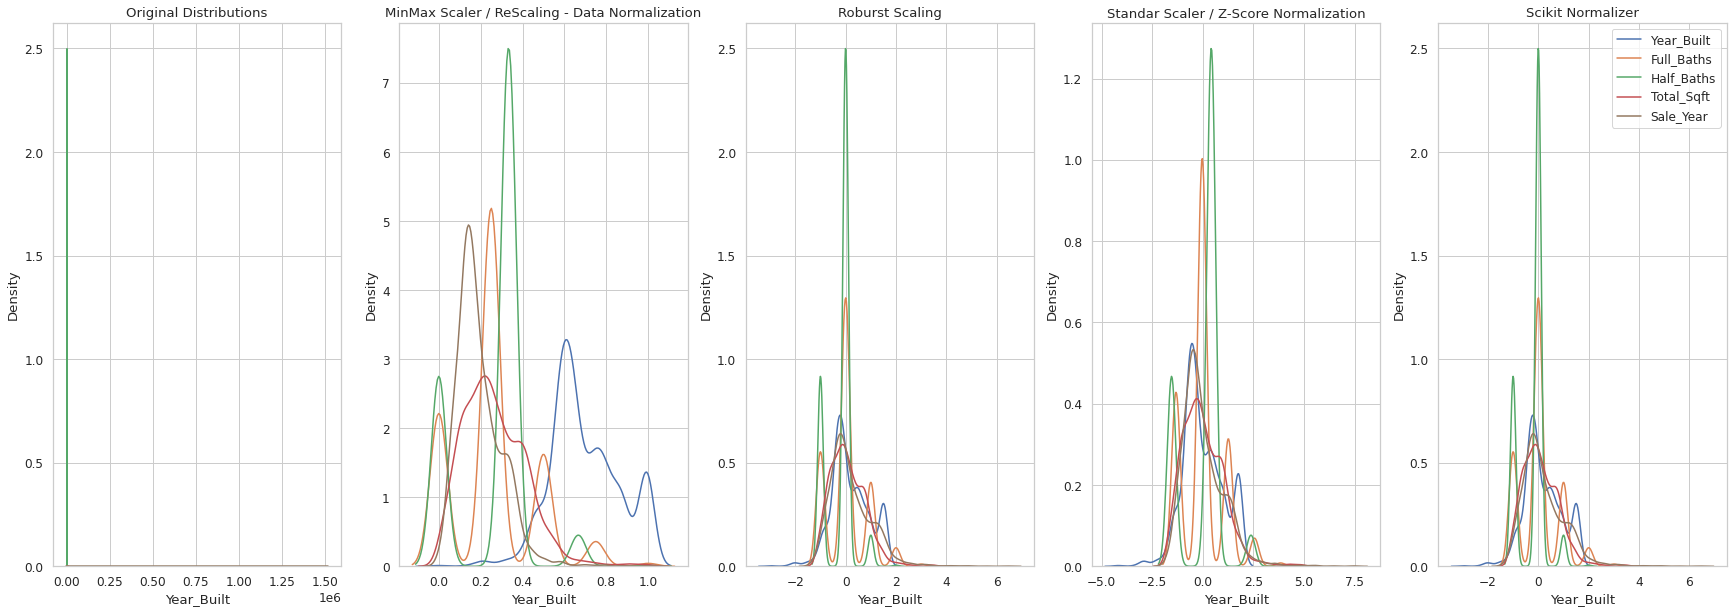

In [94]:
scaling_cols = list(x_cols)
scaling_cols.append(y_cols)
##print(scaling_cols)

df_copy_scale = pd.DataFrame ( df_house_sales, columns= scaling_cols )

df_copy_scale.head()
Plot_Scalling_Variations ( df_copy_scale)

##Step 3 : Correlation Matrix of original data
Do see any correlation?

Which columns have the strongest correlation (positive or negative) with
price.


Finding correlation between features 

All feature correlation values 
             Year_Built  Full_Baths  Half_Baths  Total_Sqft  Sale_Year   Price
Year_Built     1.00000     0.54319     0.11598     0.43182        nan 0.55172
Full_Baths     0.54319     1.00000    -0.03248     0.65317        nan 0.71060
Half_Baths     0.11598    -0.03248     1.00000     0.33756        nan 0.29360
Total_Sqft     0.43182     0.65317     0.33756     1.00000        nan 0.87399
Sale_Year          nan         nan         nan         nan        nan     nan
Price          0.55172     0.71060     0.29360     0.87399        nan 1.00000
\Target correlation with other features
 Price        1.00000
Total_Sqft   0.87399
Full_Baths   0.71060
Year_Built   0.55172
Half_Baths   0.29360
Sale_Year        nan
Name: Price, dtype: float64

Top 5 features positively impacted target 
 Price        1.00000
Total_Sqft   0.87399
Full_Baths   0.71060
Year_Built   0.55172
Half_Baths   0.29360
Name: Price, dtype: float64 


Botto

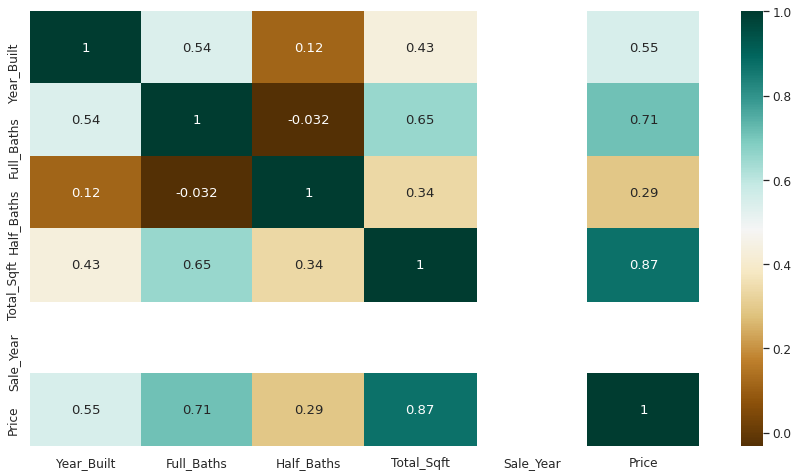

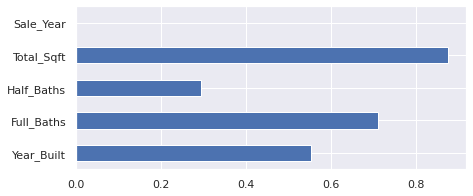

In [95]:
show_Correlation_of_lables ( df_copy_scale , y_cols)

#### Feature Selection

In [ ]:
## Since Sales_Year is not influencing the price,  we will remove it from Features.

#### Shape the data into  X, y  dataframes

In [97]:
feature_cols = x_cols.copy()
if ( feature_cols.count(y_cols)) > 0:
  feature_cols.remove(y_cols)
if ( feature_cols.count('Sale_Year')) > 0:
  feature_cols.remove('Sale_Year')
  print( "variables :{}  \nTarget :{}".format(  feature_cols ,  y_cols )  )

variables :['Year_Built', 'Full_Baths', 'Half_Baths', 'Total_Sqft']  
Target :Price


In [98]:
#Transform the data set into a data frame 
df_x = pd.DataFrame(df_copy_scale, columns = feature_cols ) 
df_y = pd.DataFrame(df_copy_scale.Price)

print( "Size of \nX :{}  \nY :{}".format(  df_x.shape ,  df_y.shape  )  )



Size of 
X :(1997, 4)  
Y :(1997, 1)


In [99]:
feature_labels  = feature_cols
target_variable = y_cols

##Step4 : Run Cross Validation

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.1s finished


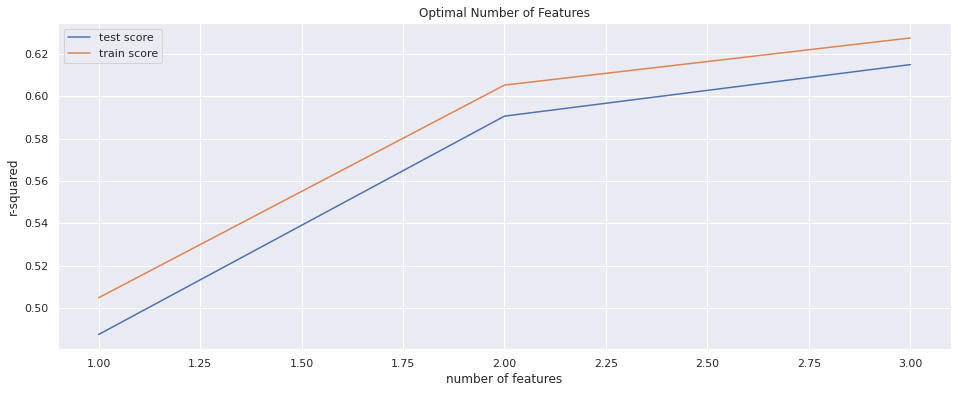

In [100]:
## We can specify more than one metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 4))}]
# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(df_x, df_y)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(df_x, df_y)  

# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)

# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

## Step5: Linear Regression

In [101]:
print ( "features {0} \ntarget : {1}".format( feature_labels, target_variable))

x_train , x_test , y_train , y_test = train_test_split(df_x , df_y, test_size = 0.20, random_state = 42)
print( "Size of \nx_train :{}  y_train :{} \nx_test :{}  y_test :{}".format(  x_train.shape ,  y_train.shape , x_test.shape, y_test.shape )  )
Run_Model (x_train , y_train , x_test , y_test ,  df_x.columns, usescaling=False, modeltype='LR',  bDebugPrint= True )

features ['Year_Built', 'Full_Baths', 'Half_Baths', 'Total_Sqft'] 
target : Price
Size of 
x_train :(1597, 4)  y_train :(1597, 1) 
x_test :(400, 4)  y_test :(400, 1)
Running ML Model 


Mean Absolute Error: 47301.2953999897
Mean Squared Error: 4828551203.967605
Root Mean Squared Error: 69487.77737104277


('LR', 0.8226186425961919, 0.8041465541860646)

##Step6- Compare score from multiple models

In [102]:
models = ['LR','mnb', 'Logistic' , 'svm', 'RFR','nn', 'nb','KNN','XGB']
model_results = []
for model_name in models:
  mdl_results = Run_Model (x_train , y_train , x_test , y_test , df_x.columns, modeltype= model_name )
  model_results.append(mdl_results)
##print ( model_results)
df = pd.DataFrame(model_results, columns =['Algorithm', 'Training_Score', 'Testing_Score' ], index=None)   
print ("================= Scores of Algorithms ===================== \n\n")
df.head(10)

================= Scores of Algorithms ===================== 




,Algorithm,Training_Score,Testing_Score
0,LR,0.82262,0.80415
1,mnb,0.03882,0.01000
2,Logistic,0.03319,0.02000
3,svm,0.02442,0.02500
4,RFR,0.97803,0.85619
5,nn,0.01565,0.01750
6,nb,0.32812,0.00000
7,KNN,0.22229,0.01000
8,XGB,0.42580,0.02000


## Next Steps
- Run Regression on Price_per_sqft
- UX development to predict with user input